In [52]:
import os
import json 

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd


In [53]:
results_dir = "sc-CNN-training/in_memory"
history_path = f"{results_dir}/histories.csv"
pymatch_path = f"{results_dir}/pymatch_results.json"

In [54]:
history = pd.read_csv(history_path, header=[0,1,2]) 
history.columns.names = ["lr", "N", "metric"]
cast_to = [float, "Int64", "string"]
history.columns = history.columns.set_levels(
  [history.columns.levels[i].astype(cast_to[i]) for i in range(len(cast_to))])

FileNotFoundError: [Errno 2] No such file or directory: 'sc-CNN-training/in_memory/histories.csv'

In [ ]:
sl = pd.IndexSlice
print(history.columns.dtypes)

history.head(3)

lr               float64
N                  Int64
metric    string[python]
dtype: object


lr         0.005                                     0.007                     \
N         10000                                     10000                       
metric      loss accuracy  val_loss val_accuracy      loss accuracy  val_loss   
0       0.607094   0.6215  0.764707      0.76525  0.619394   0.6840  0.534548   
1       0.618781   0.7855  0.537532      0.76525  0.499662   0.7855  0.508134   
2       0.533600   0.7855  0.539016      0.76525  0.481377   0.7840  0.507273   

lr                      0.005                                     0.007  \
N                      100000                                    100000   
metric val_accuracy      loss accuracy  val_loss val_accuracy      loss   
0          0.765250  0.487629  0.77940  0.443035     0.781012  0.529056   
1          0.765250  0.412140  0.78715  0.387641     0.791812  0.434595   
2          0.765125  0.360567  0.81500  0.345060     0.836187  0.388474   

lr                                      
N                                       
metric accuracy  val_loss val_accuracy  
0       0.74655  0.456352     0.771288  
1       0.78760  0.415658     0.787975  
2       0.79890  0.369709     0.814038

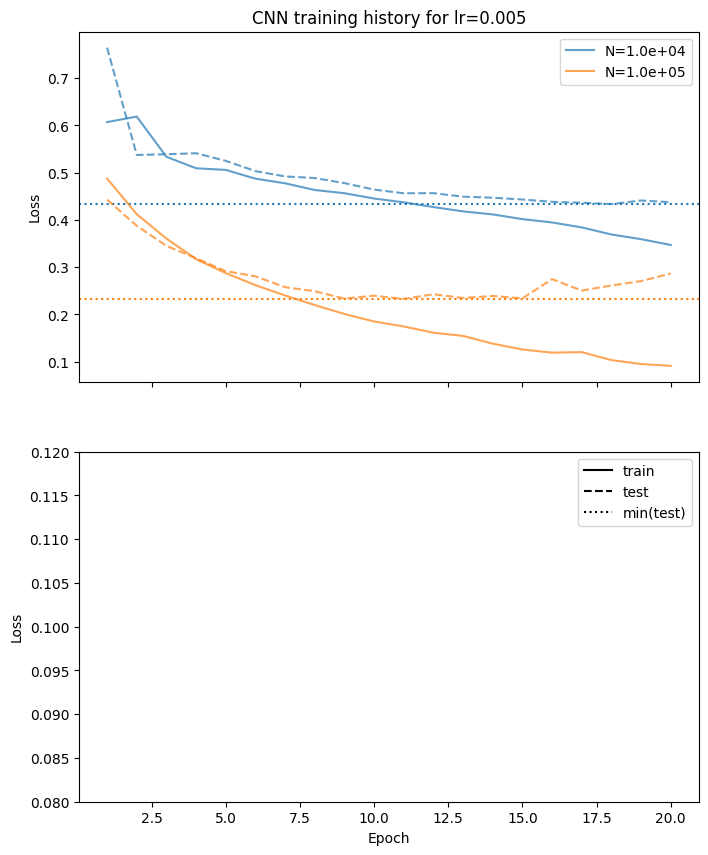

In [ ]:
epochs = np.arange(1, history.shape[0]+1)
fix_lr = 0.005 

fig, [ax_full, ax_zoom] = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
for N in history.columns.unique('N'):
    axes = [ax_full, ax_zoom] if N == 10**7 else [ax_full]
    for ax_i, ax in enumerate(axes):
        lines = ax.plot(epochs, history.loc[:, sl[fix_lr, N, 'loss']],
                        linestyle='solid', alpha=0.7,
                        label=f"N={N:0.1e}" if ax_i==0 else None)
        color = lines[-1].get_color()
        lines = ax.plot(epochs, history.loc[:, sl[fix_lr, N, 'val_loss']],
                        linestyle='dashed', alpha=0.7, color=color)
        ax.axhline(history.loc[:, sl[fix_lr, N, 'val_loss']].min(), 
                   color=color, linestyle='dotted')
ax_full.legend()
ax_zoom.plot([], [], color='black', linestyle='solid', label='train')
ax_zoom.plot([], [], color='black', linestyle='dashed', label='test')
ax_zoom.plot([], [], color='black', linestyle='dotted', label='min(test)')
ax_zoom.legend()
ax_zoom.set_ylim(0.08, 0.12)
ax_full.set_ylabel("Loss")
ax_zoom.set_ylabel("Loss")
ax_zoom.set_xlabel("Epoch")
ax_full.set_title(f"CNN training history for lr={fix_lr}")
fig.savefig(f"{results_dir}/loss-v-N__lr{fix_lr}.png")

I don't fully understand the shapes of these curves.  If our data contained noise in the sense that some labels (flip or no flip) were wrong, then it would make sense.  In that case, the training eventually starts to memorize the noise in the train set and then performs worse and worse on the test set.  But in our case we do not have that sort of noise.  So what exactly is it over-fitting to?  I would have expected in this case the test performance would not get steadily worse but rather flatten out to some asymptotic value.



In [ ]:
# get pymatching error rate 
with open(pymatch_path, "r") as f: pymatch_results = json.load(f)

In [ ]:
er_pymatch = pymatch_results['error_rate']
print(f"pymatching error rate: {100*er_pymatch:0.4}%")

pymatching error rate: 3.174%


In [ ]:
# get CNN error rate 
er = 1-history.loc[:, sl[:, :, 'accuracy']]
er.columns = er.columns.droplevel('metric')
val_er = 1-history.loc[:, sl[:, :, 'val_accuracy']]
val_er.columns = val_er.columns.droplevel('metric')

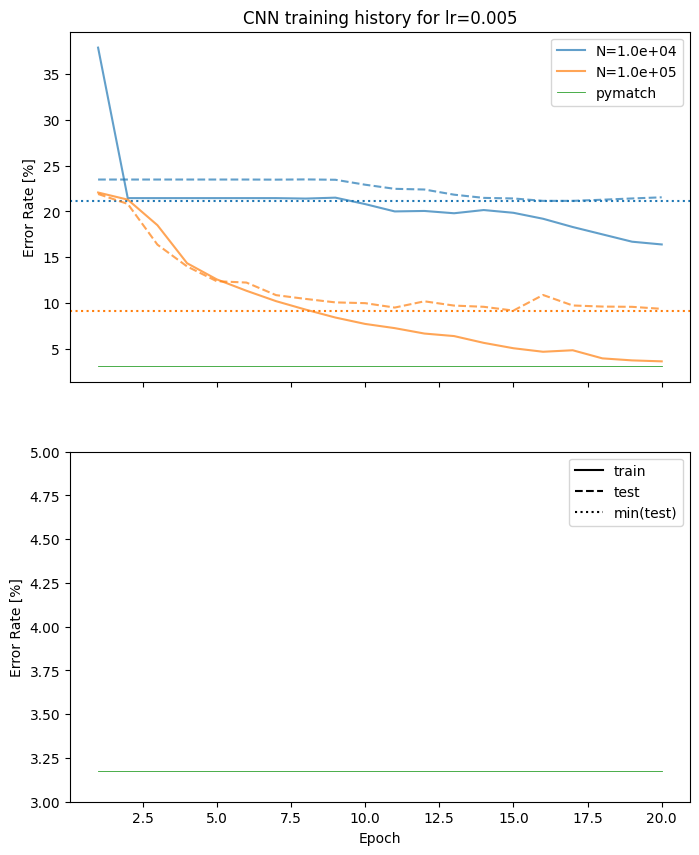

In [ ]:
fig, [ax_full, ax_zoom] = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
for N in history.columns.unique('N'):
    axes = [ax_full, ax_zoom] if N == 10**7 else [ax_full]
    for ax_i, ax in enumerate(axes):
        lines = ax.plot(epochs, 100*er.loc[:, sl[fix_lr, N]],
                        linestyle='solid', alpha=0.7, 
                        label=f"N={N:0.1e}" if ax_i==0 else None)
        color = lines[-1].get_color()
        lines = ax.plot(epochs, 100*val_er.loc[:, sl[fix_lr, N]],
                        linestyle='dashed', alpha=0.7, color=color)
        ax.axhline(100*val_er.loc[:, sl[fix_lr, N]].min(), 
                color=color, linestyle='dotted')
pymatch_color=None
for ax_i, ax in enumerate([ax_full, ax_zoom]):
     line = ax.plot(epochs, 100*er_pymatch*np.ones(epochs.shape), 
                    color=pymatch_color, linestyle='solid', linewidth=.6,
                    label='pymatch' if ax_i == 0 else None)
     pymatch_color = line[-1].get_color()
ax_full.legend()
ax_zoom.plot([], [], color='black', linestyle='solid', label='train')
ax_zoom.plot([], [], color='black', linestyle='dashed', label='test')
ax_zoom.plot([], [], color='black', linestyle='dotted', label='min(test)')
ax_zoom.legend()
ax_full.set_ylabel("Error Rate [%]")
ax_zoom.set_ylabel("Error Rate [%]")
ax_zoom.set_xlabel("Epoch")
ax_full.set_title(f"CNN training history for lr={fix_lr}")
ax_zoom.set_ylim(3, 5)
fig.savefig(f"{results_dir}/er-v-N__lr{fix_lr}.png")

Why is the error rate asympotoing but the loss increasing?  I would have thought these to be strictly correlated quantities. 

What is the uncertainty in the measured error rate?  If we treat it binary experiment (prediction is right or wrong) with probability $er$ on a sample size $N$, then $\sigma_{er} = \sqrt{er/N}$.

This is assuming that for each run of the simulation, the model has a fixed probability $er$ to get the prediction wrong regardless of what happened in that run.  I would guess this is false, but it is probably a good starting point. 

In [ ]:
# for pymatching
Nmax = history.columns.get_level_values('N').max()
sigma_er_pymatch = np.sqrt(er_pymatch/Nmax)

print(f"pymatching error rate: " 
      f"{100*er_pymatch:0.4}% +- {100*sigma_er_pymatch:0.4}%")

pymatching error rate: 3.174% +- 0.05634%


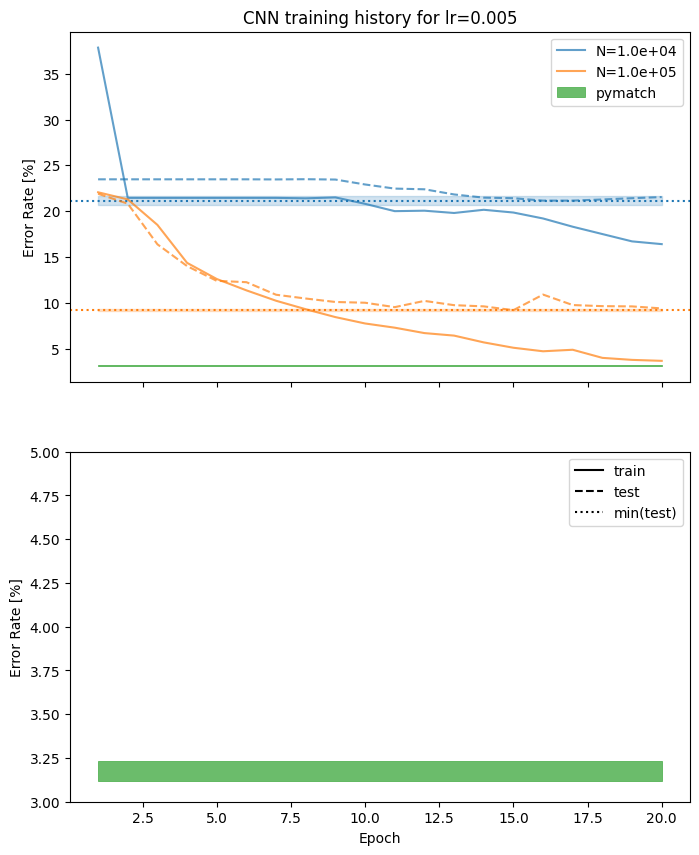

In [ ]:
fig, [ax_full, ax_zoom] = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
for N in history.columns.unique('N'):
    axes = [ax_full, ax_zoom] if N == 10**7 else [ax_full]
    for ax_i, ax in enumerate(axes):
        lines = ax.plot(epochs, 100*er.loc[:, sl[fix_lr, N]],
                        linestyle='solid', alpha=0.7, 
                        label=f"N={N:0.1e}" if ax_i==0 else None)
        color = lines[-1].get_color()
        lines = ax.plot(epochs, 100*val_er.loc[:, sl[fix_lr, N]],
                        linestyle='dashed', alpha=0.7, color=color)
        best_er = val_er.loc[:, sl[fix_lr, N]].min()
        sigma_er = np.sqrt(best_er/N)
        ax.axhline(100*best_er, color=color, linestyle='dotted')
        ax.fill_between(epochs, 100*(best_er-sigma_er), 
                        100*(best_er+sigma_er), 
                        color=color, alpha=0.2)
for ax_i, ax in enumerate([ax_full, ax_zoom]):
     line = ax.fill_between(
         epochs, 
         100*(er_pymatch-sigma_er_pymatch)*np.ones(epochs.shape), 
         100*(er_pymatch+sigma_er_pymatch)*np.ones(epochs.shape), 
         color=pymatch_color, linestyle='solid', linewidth=.6, alpha=0.7,
         label='pymatch' if ax_i == 0 else None)
ax_full.legend()
ax_zoom.plot([], [], color='black', linestyle='solid', label='train')
ax_zoom.plot([], [], color='black', linestyle='dashed', label='test')
ax_zoom.plot([], [], color='black', linestyle='dotted', label='min(test)')
ax_zoom.legend()
ax_full.set_ylabel("Error Rate [%]")
ax_zoom.set_ylabel("Error Rate [%]")
ax_zoom.set_xlabel("Epoch")
ax_full.set_title(f"CNN training history for lr={fix_lr}")
ax_zoom.set_ylim(3, 5)
fig.savefig(f"{results_dir}/er-v-N__statbands__lr{fix_lr}.png")

Why are the uncertainty bands so much smaller than the apparent noise in the dashed lines after they have flattened out?

I guess these are two unrelated uncertainties.  The shaded band is treating the model's prediction as stochastic, giving the wrong answer with fixed probability, and then measuring that probability on a finite sample size. It is the uncertainty in the error rate for a fixed model. 

But the fluctuations over epoch is comparing different models.  The training process itself is noisy and so small tweaks to hyperparameters (e.x., $\pm 1$ to epoch number) produces models with different error rates.  The plots are telling us that this variance dominates. 

In [ ]:
val_er.head(3)

lr,0.005,0.007,0.005,0.007
N,10000,10000,100000,100000
0,0.23475,0.234750,0.218988,0.228712
1,0.23475,0.234750,0.208188,0.212025
2,0.23475,0.234875,0.163813,0.185962


In [ ]:
best_er = pd.DataFrame(val_er.min(axis=0), columns=['er'])
best_er["sigma_train"] = val_er.iloc[-20:, :].std(axis=0)
best_er["sigma_stat"] = np.sqrt(best_er.er/best_er.index.get_level_values('N'))
best_er["sigma"] = np.sqrt(best_er["sigma_train"]**2 + 
                           best_er["sigma_stat"]**2)

In [ ]:
er_pymatch = pymatch_results['error_rate']
Nmax = history.columns.get_level_values('N').max()
sigma_er_pymatch = np.sqrt(er_pymatch/Nmax)

print(f"pymatching error rates: {100*er_pymatch:0.4}% +- {100*sigma_er_pymatch:0.4}%")
print()
print(f"CNN test error percent:")   
print(best_er*100)

pymatching error rates: 3.174% +- 0.05634%

CNN test error percent:
                     er  sigma_train  sigma_stat     sigma
lr    N                                                   
0.005 10000   21.149999     0.990281    0.459891  1.091859
0.007 10000   21.662498     0.665076     0.46543  0.811758
0.005 100000   9.192502     3.716996    0.095878  3.718232
0.007 100000   9.932500     3.958661    0.099662  3.959915


Text(0.5, 1.0, 'Best error rate for lr=0.005')

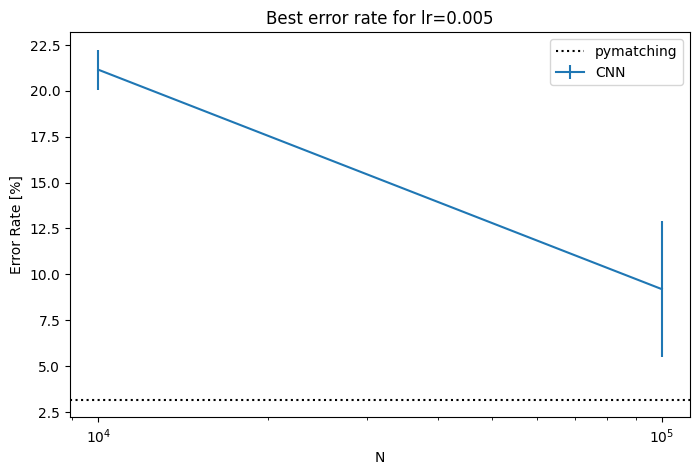

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.errorbar(best_er.loc[fix_lr, :].index, 
            100*best_er.loc[fix_lr, :].er, 
            100*best_er.loc[fix_lr, :].sigma, 
            fmt='', label='CNN')
ax.axhline(100*er_pymatch, color='black', linestyle='dotted', label='pymatching')
ax.legend()
ax.set_xscale('log')
ax.set_ylabel("Error Rate [%]")
ax.set_xlabel("N")
ax.set_title(f"Best error rate for lr={fix_lr}")


How close will $10^8$ get us?  This is too big to run in memory - need to implement file streaming. 

How does changing the learning rate effect things?

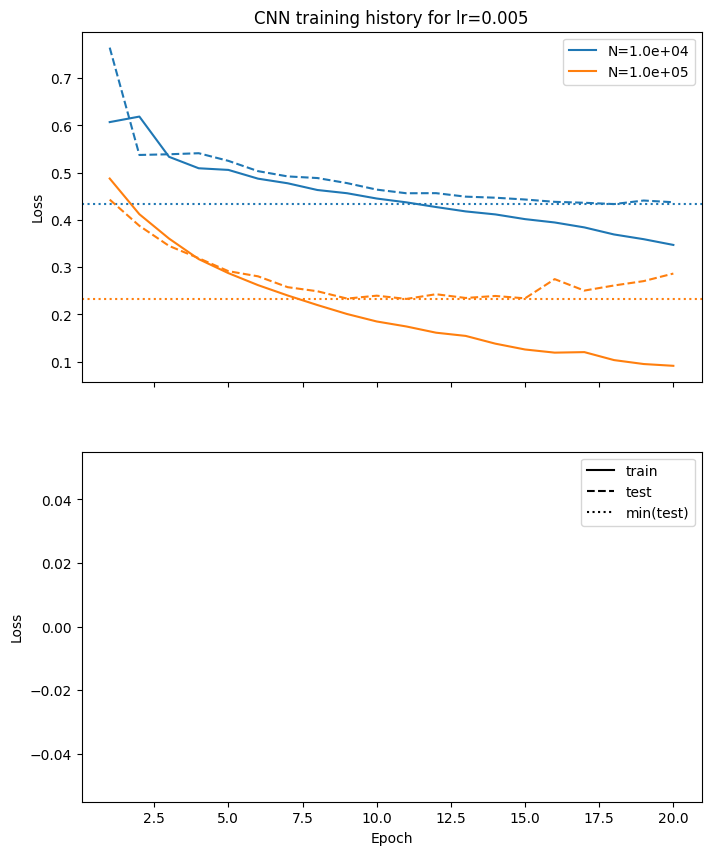

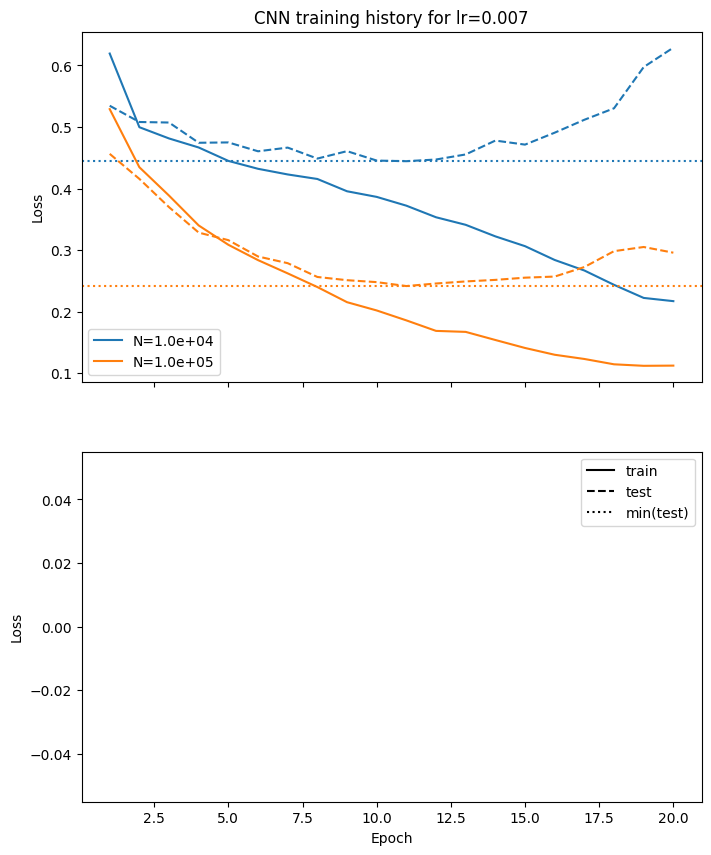

In [ ]:
epochs = np.arange(1, history.shape[0]+1)

for lr in history.columns.unique('lr').sort_values():
    fig, [ax_full, ax_zoom] = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
    for N in history.columns.unique('N'):
        axes = [ax_full, ax_zoom] if N == 10**7 else [ax_full]
        for ax_i, ax in enumerate(axes):
            lines = ax.plot(epochs, history.loc[:, sl[lr, N, 'loss']],
                            linestyle='solid', 
                            label=f"N={N:0.1e}" if ax_i==0 else None)
            color = lines[-1].get_color()
            lines = ax.plot(epochs, history.loc[:, sl[lr, N, 'val_loss']],
                            linestyle='dashed', color=color)
            ax.axhline(history.loc[:, sl[lr, N, 'val_loss']].min(), 
                    color=color, linestyle='dotted')
    ax_full.legend()
    ax_zoom.plot([], [], color='black', linestyle='solid', label='train')
    ax_zoom.plot([], [], color='black', linestyle='dashed', label='test')
    ax_zoom.plot([], [], color='black', linestyle='dotted', label='min(test)')
    ax_zoom.legend()
    # ax_zoom.set_ylim(0.08, 0.12)
    ax_full.set_ylabel("Loss")
    ax_zoom.set_ylabel("Loss")
    ax_zoom.set_xlabel("Epoch")
    ax_full.set_title(f"CNN training history for lr={lr}")
    fig.savefig(f"{results_dir}/loss-v-N__lr{lr}.png")

This is sensible, smaller values just slow down convergence but too large causes it to go crazy.  It seems convergence is slower for larger N, so I would think we want larger learning rate for larger N, but in practice that doesn't seem right.  The transition to crazy is just too sudden. 

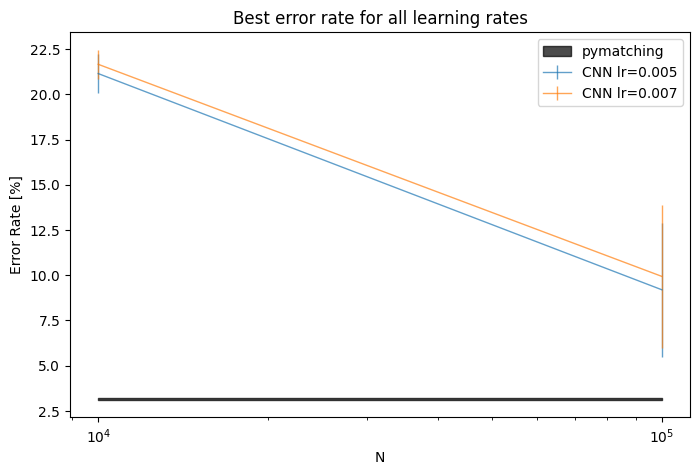

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

for lr in history.columns.unique('lr').sort_values():
    ax.errorbar(best_er.loc[lr, :].index, 
                100*best_er.loc[lr, :].er, 
                100*best_er.loc[lr, :].sigma, 
                marker='', label=f'CNN lr={lr}', 
                linestyle='solid', linewidth=1, alpha=0.7)
x = best_er.loc[lr, :].index
ax.fill_between(x, 100*(er_pymatch - sigma_er_pymatch)*np.ones(x.shape),
                100*(er_pymatch + sigma_er_pymatch)*np.ones(x.shape), 
                color='black', label='pymatching', alpha=0.7)
ax.legend()
ax.set_xscale('log')
ax.set_ylabel("Error Rate [%]")
ax.set_xlabel("N")
ax.set_title(f"Best error rate for all learning rates")
fig.savefig(f"{results_dir}/best_er-v-N_lr.png")